In [2]:
import fastai
import os
import pprint
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from datetime import (
    datetime
)

from sklearn.preprocessing import (
    StandardScaler
)

from typing import (
    Callable,
    Dict,
    List,
    Tuple
)

from Quick.cleaning.loading import (
    examine_dataset,
    remove_infs_and_nans
)

from Quick.cleaning.utils import (
    get_file_path
)

from Quick.runners.deep import (
    run_deep_nn_experiment
)

from Quick.runners.residual import (
    run_residual_deep_nn_experiment
)

from Quick.runners.sk import (
    run_sk_experiment
)

from Quick.runners.torch import (
    run_torch_nn_experiment
)

from rff.layers import (
    GaussianEncoding,
)


from Quick.constants import *

pretty = pprint.PrettyPrinter(indent=4).pprint

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
use_gpu: bool = False

if(use_gpu):

    if(torch.backends.mps.is_available()): # For Mac M1/M2 chips
        device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    else: # For NVIDIA cuda chips
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

else:
    device = torch.device('cpu')

print(f'We are currently using the device: {device}')

We are currently using the device: cpu


## We are currently using the CICDDoS-2019 dataset from the Canadian Institute of Cybersecurity, found [here](https://www.unb.ca/cic/datasets/ddos-2019.html). 

Download the csv files in zip form from the website and extract the zip in the ..data directory

In [4]:
ddos_data_path_1: str = '../data/01-12/'
ddos_data_path_2: str = '../data/03-11/'

# Raw datasets, still contain infs/nans/empty and are all primarily 1 class
ddos_data_1: list = [ # https://www.unb.ca/cic/datasets/ddos-2019.html
    'DrDoS_NTP.csv',
    'DrDoS_DNS.csv',
    'DrDoS_LDAP.csv',
    'DrDoS_MSSQL.csv',
    'DrDoS_NetBIOS.csv',
    'DrDoS_SNMP.csv',
    'DrDoS_SSDP.csv',
    'DrDoS_UDP.csv',
    'UDPLag.csv',
    'Syn.csv',
    'TFTP.csv',
]

# Raw datasets, still contain infs/nans/empty and are all primarily 1 class
ddos_data_2: list = [ # https://www.unb.ca/cic/datasets/ddos-2019.html
    'Portmap.csv',
    'NetBIOS.csv',
    'LDAP.csv',
    'MSSQL.csv',
    'UDP.csv',
    'UDPLAG.csv',
    'SYN.csv'
]


# Now we package the datasets and load when necessary
ddos_path_1: callable = get_file_path(ddos_data_path_1)
ddos_path_2: callable = get_file_path(ddos_data_path_2)

ddos_datasets_1: list = list(map(ddos_path_1, ddos_data_1))
ddos_datasets_2: list = list(map(ddos_path_2, ddos_data_2))

print(f'The datasets we will be working with are:')
pretty(ddos_datasets_1)
print('and')
pretty(ddos_datasets_2)

The datasets we will be working with are:
[   '../data/01-12/DrDoS_NTP.csv',
    '../data/01-12/DrDoS_DNS.csv',
    '../data/01-12/DrDoS_LDAP.csv',
    '../data/01-12/DrDoS_MSSQL.csv',
    '../data/01-12/DrDoS_NetBIOS.csv',
    '../data/01-12/DrDoS_SNMP.csv',
    '../data/01-12/DrDoS_SSDP.csv',
    '../data/01-12/DrDoS_UDP.csv',
    '../data/01-12/UDPLag.csv',
    '../data/01-12/Syn.csv',
    '../data/01-12/TFTP.csv']
and
[   '../data/03-11/Portmap.csv',
    '../data/03-11/NetBIOS.csv',
    '../data/03-11/LDAP.csv',
    '../data/03-11/MSSQL.csv',
    '../data/03-11/UDP.csv',
    '../data/03-11/UDPLAG.csv',
    '../data/03-11/SYN.csv']


# Data Pre-processing

We define a class to handle the preprocessing

In [5]:
class Preprocessor:
    map_index_key = '__map_index__'
    category_map = {}
    old_maps = []

    def __init__(
        self,
        pipeline: List[Callable[[pd.DataFrame], pd.DataFrame]],
        device: torch.device,
    ) -> None:

        self.pipeline = pipeline
        self.device = device

        self.fitted = False

    def fit(self, X: pd.DataFrame, leave_out: List[str] = ['Timestamp']):

        X = X.copy()
        for col in leave_out:
            if col in X.columns:
                X = X.drop(columns=[col])

        for step in self.pipeline:
            step.fit(X)

        self.fitted = True

        return self

    def transform(
        self, 
        X: pd.DataFrame,
        leave_out: List[str] = ['Timestamp']
    ) -> pd.DataFrame:

        if not self.fitted:
            raise Exception('E1: You must fit the preprocessor before transforming')
    
        X = X.copy()
        
        if leave_out != []:
            left_out = X[leave_out]
            X = X.drop(columns=leave_out)

        columns = X.columns

        for col in leave_out:
            if col in columns:
                raise Exception('E2: Undesired column %s was found in the transformed dataset' % col)

        for step in self.pipeline:
            X = step.transform(X)

        X = pd.DataFrame(X, columns=columns)

        if leave_out != []:
            for col in leave_out:
                X[col] = left_out[col]
            # X[leave_out] = left_out

        for col in leave_out:
            if col not in X.columns:
                raise Exception('E3: Column %s was not found in the transformed dataset' % col)

        return X

    def index_categories(
        self, 
        X: pd.DataFrame, 
        categorical_cols: List[str]
    ) -> pd.DataFrame:
        '''
            We need to index the categorical columns so that they are in the range [0, n_categories) and save the mapping
        '''
        X = X.copy()

        if self.map_index_key in categorical_cols:
            raise Exception('Cannot use the reserved key %s as a column name' % self.map_index_key)

        if self.category_map != {}:
            self.old_maps.append(self.category_map)
        
        old_mapping_index = len(self.old_maps)

        for col in categorical_cols:
            X[col], self.category_map[col] = pd.factorize(X[col])
            self.category_map[self.map_index_key] = old_mapping_index    

        return X

    def create_dataset(
        self, 
        dataset: pd.DataFrame,
        categorical_cols: List[str],
        relative_cols: List[str],
        other_cols: Dict[str, List[str]],
        context_sequence_length: int = 1,
        target_sequence_length: int = 1,
        target_sequence_offset: int = 0,
    ) -> Dict[str, torch.Tensor]:
        '''
            We create a dataset for each column group where each shares the same index
            in the first dimension

            This is because the groups will have different lengths in the last dimension
            

            We also need to create a context and target sequence for each column group
                where the context sequence is the input and the target sequence is the output
            
                for each sample s in the dataset:
                    context_sequence = df[s:s+context_sequence_length]
                    target_sequence = df[s+target_sequence_offset:s+target_sequence_offset+target_sequence_length]


        '''
        
        if not self.fitted:
            self.fit(
                dataset, 
                leave_out=relative_cols + categorical_cols
            )

        dataset = self.transform(
            dataset,
            leave_out=relative_cols + categorical_cols
        )

        bounds = max(
            context_sequence_length, 
            target_sequence_length + target_sequence_offset
        )

        dataset_groups = {}

        for i, (name, group) in enumerate(other_cols.items()):
            dataset_groups[name] = dataset[group]

        categorical_data = dataset[categorical_cols]
        categorical_data = self.index_categories(categorical_data, categorical_cols)

        relative_data = dataset[relative_cols]

        output = {}

        src = '_source'
        tgt = '_target'

        output['categorical_data' + src] = []
        output['categorical_data' + tgt] = []
        output['relative_data' + src] = []
        output['relative_data' + tgt] = []
    
        for name in other_cols.keys():
            output[name + src] = []
            output[name + tgt] = []

        for i in range(len(dataset) - bounds):
            
            output['categorical_data' + src].append(
                categorical_data[i:i+context_sequence_length].values
            )

            output['categorical_data' + tgt].append(
                categorical_data[i+target_sequence_offset:i+target_sequence_offset+target_sequence_length].values
            )

            relative_source = relative_data[i:i+context_sequence_length].values

            relative_target = relative_data[i+target_sequence_offset:i+target_sequence_offset+target_sequence_length].values

            relative_source = relative_source - relative_source[0]
            relative_target = relative_target - relative_source[0]

            output['relative_data' + src].append(
                relative_source
            )

            output['relative_data' + tgt].append(
                relative_target
            )
            

            for name in dataset_groups.keys():
                output[name + src].append(
                    dataset_groups[name][i:i+context_sequence_length].values
                )

                output[name + tgt].append(
                    dataset_groups[name][i+target_sequence_offset:i+target_sequence_offset+target_sequence_length].values
                )

        for name in output.keys():
            if name == 'categorical_data' + src or name == 'categorical_data' + tgt:
                output[name] = torch.tensor(output[name], dtype=torch.long, device=self.device)
            else:
                output[name] = torch.tensor(output[name], dtype=torch.float32, device=self.device)

        return output

In [6]:
dataset_1 = examine_dataset(1, ddos_datasets_1, ddos_data_1)

Dataset 1/11: We now look at ../data/01-12/DrDoS_NTP.csv


Loading Dataset: ../data/01-12/DrDoS_NTP.csv
	To Dataset Cache: ./cache/DrDoS_NTP.csv.pickle


        File:				../data/01-12/DrDoS_NTP.csv  
        Job Number:			1
        Shape:				(1217007, 88)
        Samples:			1217007 
        Features:			88
    


Before we can use the preprocessor, we must load and clean our dataset. 

Since this is a prototype, we only load 1 of the datasets

In [7]:
ddos: pd.DataFrame = remove_infs_and_nans(dataset_1)
ddos.columns = [column.strip() for column in ddos.columns]

timestamps = ddos['Timestamp']
std_time = timestamps.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').timestamp())
ddos['Timestamp'] = std_time

ddos = ddos.sort_values(by=['Timestamp'])

deleting 7015 rows with Infinity in column Flow Bytes/s


This next cell contains all of the groups of columns. Each group will be used in a slightly different way

In [8]:
time_cols= [
    'Timestamp',
]

cont_cols = [
    'Flow Bytes/s',

    'Bwd Packets/s',
    'Fwd Packets/s',
    'Flow Packets/s',
    
    'Down/Up Ratio',
    'ACK Flag Count',
    'CWE Flag Count',
    'ECE Flag Count',
    'FIN Flag Count',
    'PSH Flag Count',
    'RST Flag Count',
    'SYN Flag Count',
    'URG Flag Count',
    
    'Flow Duration',

    'Bwd PSH Flags',
    'Fwd PSH Flags',
    'Bwd URG Flags',
    'Fwd URG Flags',

    'Bwd Header Length',
    
    'Total Length of Fwd Packets',
    'Total Length of Bwd Packets',
    'Fwd Header Length',
    
    'Total Backward Packets',
    'Total Fwd Packets',
    'Subflow Bwd Packets',
    'Subflow Fwd Packets',
    
    'Subflow Fwd Bytes',
    'Subflow Bwd Bytes',

    'Bwd IAT Total',
    'Fwd IAT Total',

    'act_data_pkt_fwd',
    'Init_Win_bytes_backward',
    'Init_Win_bytes_forward',
    'Active Min',
    'Idle Min',

    'Bwd IAT Min',
    'Fwd IAT Min',
    'Flow IAT Min',
    
    'Bwd Packet Length Min',
    'Fwd Packet Length Min',
    'Min Packet Length',

    'min_seg_size_forward',

    'Active Max',
    'Idle Max',

    'Bwd IAT Max',
    'Fwd IAT Max',
    'Flow IAT Max',
    
    'Max Packet Length',
    'Bwd Packet Length Max',
    'Fwd Packet Length Max',

    'Active Mean',
    'Idle Mean',

    'Bwd Avg Bulk Rate',
    'Fwd Avg Bulk Rate',
    
    'Bwd Avg Bytes/Bulk',
    'Fwd Avg Bytes/Bulk',
    
    'Bwd IAT Mean',
    'Fwd IAT Mean',
    'Flow IAT Mean',
    
    'Packet Length Mean',
    'Bwd Packet Length Mean',
    'Fwd Packet Length Mean',
    
    'Average Packet Size',
    'Bwd Avg Packets/Bulk',
    'Fwd Avg Packets/Bulk',
    
    'Avg Bwd Segment Size',
    'Avg Fwd Segment Size',

    'Active Std',
    'Idle Std',
    
    'Bwd IAT Std',
    'Fwd IAT Std',
    'Flow IAT Std',

    'Packet Length Std',
    'Packet Length Variance',
    'Bwd Packet Length Std',
    'Fwd Packet Length Std',
]

categorical_cols = {
    # column: number_of_possible_classes
    'Protocol': 256,
    'Inbound': 2,
}

port_cols = [
    'Destination Port',
    'Source Port',
]

unused_cols = [
    'Unnamed: 0',
    'Flow ID',
    'Source IP',
    'Destination IP',
    'SimillarHTTP',
    'Label',
    'Fwd Header Length.1'
] + port_cols

# concatenate all column groups together to get a list of all columns
all_cols = port_cols + time_cols + list(categorical_cols.keys()) + cont_cols + unused_cols

# all_cols = time_cols + categorical_cols + min_cols + max_cols + mean_cols + std_cols + length_cols + unused_cols

 
if set(ddos.columns) - set(all_cols) != set():
    print('There are unaccounted for columns')
else:
    print('All columns are accounted for')

All columns are accounted for


In [9]:
column_groups = {
    'cont_cols': cont_cols,
}

In [10]:
ddos_clean = ddos.copy().drop(columns=unused_cols)

Finally, now that we have a clean dataset and we know how we are grouping the columns, we can use the preprocessor on the data and create a dataset.

The datasets will consist of context (or source) and target sequences. The offset determines the starting index of the target sequence relative to the context sequence

In [152]:
class Preprocessor:
    map_index_key = '__map_index__'
    category_map = {}
    old_maps = []

    def __init__(
        self,
        pipeline: List[Callable[[pd.DataFrame], pd.DataFrame]],
        device: torch.device,
    ) -> None:

        self.pipeline = pipeline
        self.device = device

        self.fitted = False

    def fit(self, X: pd.DataFrame, leave_out: List[str] = ['Timestamp']):

        X = X.copy()
        for col in leave_out:
            if col in X.columns:
                X = X.drop(columns=[col])

        for step in self.pipeline:
            step.fit(X)

        self.fitted = True

        return self

    def transform(
        self, 
        df: pd.DataFrame,
        leave_out: List[str] = ['Timestamp']
    ) -> pd.DataFrame:

        if not self.fitted:
            raise Exception('E1: You must fit the preprocessor before transforming')
    
        X = df.copy()
        df = df.copy()

        if leave_out != []:
            # print(leave_out)
            left_out = X[leave_out].copy()
            X = X.drop(columns=leave_out)

        columns: list = X.columns

        for col in leave_out:
            if col in columns:
                raise Exception('E2: Undesired column %s was found in the transformed dataset' % col)

        for step in self.pipeline:
            X: np.ndarray = step.transform(X)

        X = pd.DataFrame(X, columns=columns)
        # df[columns].values = X

        # df = pd.DataFrame(np.concatenate(X, left_out.values), columns = columns.extend(leave_out))

        # if leave_out != []:
        #     for col in leave_out:
        #         df[col] = left_out[col]
        #         # X[col] = left_out[col]
        #     # X[leave_out] = left_out

        for col in columns:
            df[col] = X[col]

        for col in leave_out:
            if col not in df.columns:
                raise Exception('E3: Column %s was not found in the transformed dataset' % col)

        return X

    def index_categories(
        self, 
        X: pd.DataFrame, 
        categorical_cols: List[str]
    ) -> pd.DataFrame:
        '''
            We need to index the categorical columns so that they are in the range [0, n_categories) and save the mapping
        '''
        X = X.copy()

        if self.map_index_key in categorical_cols:
            raise Exception('Cannot use the reserved key %s as a column name' % self.map_index_key)

        if self.category_map != {}:
            self.old_maps.append(self.category_map)
        
        old_mapping_index = len(self.old_maps)

        for col in categorical_cols:
            X[col], self.category_map[col] = pd.factorize(X[col])
            self.category_map[self.map_index_key] = old_mapping_index    

        return X

    def create_dataset(
        self, 
        dataset: pd.DataFrame,
        categorical_cols: List[str],
        relative_cols: List[str],
        other_cols: Dict[str, List[str]],
        context_sequence_length: int = 1,
        target_sequence_length: int = 1,
        target_sequence_offset: int = 0,
    ) -> Dict[str, torch.Tensor]:
        '''
            We create a dataset for each column group where each shares the same index
            in the first dimension

            This is because the groups will have different lengths in the last dimension
            

            We also need to create a context and target sequence for each column group
                where the context sequence is the input and the target sequence is the output
            
                for each sample s in the dataset:
                    context_sequence = df[s:s+context_sequence_length]
                    target_sequence = df[s+target_sequence_offset:s+target_sequence_offset+target_sequence_length]


        '''
        
        output = {}

        src = '_source'
        tgt = '_target'

        if not self.fitted:
            self.fit(
                dataset, 
                leave_out=relative_cols + categorical_cols
            )

        categorical_data = dataset[categorical_cols]
        relative_data = dataset[relative_cols]
        # print(categorical_data[100:])

        dataset = self.transform(
            dataset,
            leave_out=relative_cols + categorical_cols
        )

        # categorical_data = dataset[categorical_cols]
        # print(dataset[100:])
        # print(categorical_data[100:])
        
        bounds = max(
            context_sequence_length, 
            target_sequence_length + target_sequence_offset
        )

        dataset_groups = {}

        for i, (name, group) in enumerate(other_cols.items()):
            dataset_groups[name] = dataset[group]

        # categorical_data = dataset[categorical_cols]
        # print(categorical_data[100:])
        # categorical_data = self.index_categories(categorical_data, categorical_cols)
        # print(categorical_data[100:])


        output['categorical_data' + src] = []
        output['categorical_data' + tgt] = []
        output['relative_data' + src] = []
        output['relative_data' + tgt] = []
    
        for name in other_cols.keys():
            output[name + src] = []
            output[name + tgt] = []

        for i in range(len(dataset) - bounds):
            
            output['categorical_data' + src].append(
                categorical_data[i:i+context_sequence_length].values
            )

            output['categorical_data' + tgt].append(
                categorical_data[i+target_sequence_offset:i+target_sequence_offset+target_sequence_length].values
            )

            relative_source = relative_data[i:i+context_sequence_length].values

            relative_target = relative_data[i+target_sequence_offset:i+target_sequence_offset+target_sequence_length].values

            # relative_source = relative_source - relative_source[0]
            # relative_target = relative_target - relative_source[0]

            output['relative_data' + src].append(
                relative_source
            )

            output['relative_data' + tgt].append(
                relative_target
            )
            

            for name in dataset_groups.keys():
                output[name + src].append(
                    dataset_groups[name][i:i+context_sequence_length].values
                )

                output[name + tgt].append(
                    dataset_groups[name][i+target_sequence_offset:i+target_sequence_offset+target_sequence_length].values
                )

        for name in output.keys():
            if name == 'categorical_data' + src or name == 'categorical_data' + tgt:
                # print("asdf", output[name][-1])
                # print(output[name])
                output[name] = torch.tensor(output[name], dtype=torch.long, device=self.device)
                # print(output[name][-1])
            else:
                output[name] = torch.tensor(output[name], dtype=torch.float32, device=self.device)

        return output

In [153]:
process = Preprocessor([StandardScaler()], device)

context_length = 10
target_length = 1
target_offset = 9

data_dict = process.create_dataset(
    # ddos_clean,
    ddos_clean[:5000], # we only select 10000 samples for now
    list(categorical_cols.keys()),
    time_cols,
    column_groups,
    context_sequence_length=context_length,
    target_sequence_length=target_length,
    target_sequence_offset=target_offset
)

for name, tensor in data_dict.items():
    print(name, tensor.shape)

categorical_data_source torch.Size([4990, 10, 2])
categorical_data_target torch.Size([4990, 1, 2])
relative_data_source torch.Size([4990, 10, 1])
relative_data_target torch.Size([4990, 1, 1])
cont_cols_source torch.Size([4990, 10, 76])
cont_cols_target torch.Size([4990, 1, 76])


We prepare the dataset for consumption by our model by wrapping it in a handy torch container and splitting it into train/test datasets

In [154]:
list(data_dict.keys())

['categorical_data_source',
 'categorical_data_target',
 'relative_data_source',
 'relative_data_target',
 'cont_cols_source',
 'cont_cols_target']

In [155]:

# Now we use the TensorDataset function to wrap all of the different parts of dataset. 
# The first dimension must be the same size across all inputs
tensor_dataset = data.TensorDataset(
    data_dict['relative_data_source'],
    data_dict['categorical_data_source'],
    data_dict['cont_cols_source'],
    # data_dict['speed_cols_source'],
    # data_dict['length_cols_source'],
    # data_dict['min_cols_source'],
    # data_dict['max_cols_source'],
    # data_dict['mean_cols_source'],
    # data_dict['std_cols_source'],
    data_dict['relative_data_target'],
    data_dict['categorical_data_target'],
    data_dict['cont_cols_target']
    # data_dict['speed_cols_target'],
    # data_dict['length_cols_target'],
    # data_dict['min_cols_target'],
    # data_dict['max_cols_target'],
    # data_dict['mean_cols_target'],
    # data_dict['std_cols_target'],
)


# We can now randomly split off a train and test dataset from the TensorDataset
train_size = int(len(tensor_dataset) * 0.8)
test_size = len(tensor_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(tensor_dataset, [train_size, test_size])   

Given a batch size, we create our dataloaders. These will randomize the minibatches for use by the model during each epoch

In [156]:
batch_size = 12

train_dataloader = data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

# The Model

Now that we have a dataset and we understand its structure, we can begin to build the model

The embeddings for the model

In [157]:
class EmbeddingDropout(nn.Module):
    
    def __init__(
        self,
        p: float = .05,
    ):
        super(EmbeddingDropout, self).__init__()

        self.p = p

    def forward(self, embeddings: List[torch.Tensor]) -> torch.Tensor:
        # print(f"training: {self.training}")

        if not self.training:
            return sum(embeddings)

        else:
            mask = torch.rand(
                embeddings[0].shape[0],
                embeddings[0].shape[1],
                len(embeddings), 
                1, 
                device=embeddings[0].device
            ) < self.p

            mask = mask.float()

            return sum([mask[:, :, i, :] * emb for i, emb in enumerate(embeddings)])


class RandomFourierTimeEncoding(nn.Module):

    def __init__(
        self,
        device: torch.device,
        input_size: int = 1,
        encoding_half_size: int = 50,
        sigma: float = 4,
    ) -> None:
        super(RandomFourierTimeEncoding, self).__init__()

        self.fourier = GaussianEncoding(
            sigma=sigma,
            input_size=input_size,
            encoded_size=encoding_half_size,
        ).to(device)
        # )

    def forward(
        self,
        X: torch.Tensor,
    ) -> torch.Tensor:
        '''
            X: (batch_size, sequence_length, input_size)
            output: (batch_size, sequence_length, 2*encoding_half_size + input_size)
        '''

        output = self.fourier(X)
        output = torch.cat([X, output], dim=-1)

        return output

The Generative Head

In [158]:
class TrafficGenerativeHead(nn.Module):
    '''
        This is the head of the decoder.

        params:
            input_size: the size of the last dimension of the input
            categorical_cols: a dictionary of column names and the number of categories in each column
            column_groups: a dictionary of column groups, each with a group name a list of column names
            

        For each categorical column, we create a classification trunk of layers that will end in a softmax layer of size num_categories
        For each column group, we create a regression trunk of layers that will end in a linear layer that is the length of the column group
    '''

    def __init__(
        self, 
        input_size: int, 
        categorical_cols: Dict[str, int],
        column_groups: Dict[str, List[str]],
        device: torch.device,
    ) -> None:
    
        super(TrafficGenerativeHead, self).__init__()

        self.input_size = input_size
        self.categorical_cols = categorical_cols
        self.column_groups = column_groups
        self.device = device

        self.categorical_head = nn.ModuleDict()

        for column, num_categories in categorical_cols.items():
            hidden_size = (input_size + num_categories) // 2
            self.categorical_head[column] = nn.Sequential(
                nn.Linear(input_size, hidden_size, device = device),
                nn.ReLU(),
                nn.Linear(hidden_size, num_categories, device = device),
                nn.Softmax(dim=-1)
            )

        self.continuous_head = nn.ModuleDict()

        for column_group, columns in column_groups.items():
            hidden_size = (input_size + len(columns)) // 2
            self.continuous_head[column_group] = nn.Sequential(
                nn.Linear(input_size, hidden_size, device = device),
                nn.ReLU(),
                nn.Linear(hidden_size, len(columns), device = device),
            )

        # self.inspector = DebugLayer()


    def forward(self, x):

        # x = self.inspector(x)

        # print(f"generative head input shape: {x.shape}")

        cont_output = torch.cat(
            [head(x) for head in self.continuous_head.values()],
            dim= -1
        )

        cat_output = torch.cat(
            [head(x) for head in self.categorical_head.values()],
            dim= -1
        )

        return cont_output, cat_output










# TESTING
# Here we test the generative head using some dummy data


batch_size: int = 3
samples: int    = 4
variables: int  = 5

column_groups = {
    'sample_group_1':[
        'col_1',
        'col_2',
    ],
    'sample_group_2': [
        'col_3',
        'col_4',
        'col_5',
    ],
}

categorical_columns = {
    'cat_1': 2,
    'cat_2': 3,
}

test_vals = torch.rand(batch_size, samples, variables)


model = TrafficGenerativeHead(variables, categorical_columns, column_groups, device)
model(test_vals)

(tensor([[[ 0.4214, -0.1460, -0.4201, -0.2688,  0.1983],
          [ 0.4217, -0.1456, -0.4333, -0.1825,  0.1872],
          [ 0.4152, -0.1700, -0.4111, -0.1201,  0.2070],
          [ 0.4163, -0.1869, -0.4323, -0.2181,  0.1868]],
 
         [[ 0.4164, -0.1543, -0.4079, -0.1991,  0.2082],
          [ 0.4243, -0.1457, -0.4454, -0.1870,  0.1774],
          [ 0.4217, -0.1456, -0.4442, -0.3052,  0.1766],
          [ 0.4226, -0.1441, -0.4699, -0.1998,  0.1574]],
 
         [[ 0.4156, -0.1555, -0.4115, -0.1725,  0.2056],
          [ 0.4225, -0.1443, -0.4235, -0.1849,  0.1949],
          [ 0.4220, -0.1451, -0.4121, -0.1256,  0.2060],
          [ 0.4255, -0.1393, -0.4520, -0.1732,  0.1726]]],
        grad_fn=<CatBackward0>),
 tensor([[[0.3296, 0.6704, 0.5269, 0.1494, 0.3237],
          [0.3405, 0.6595, 0.6092, 0.1242, 0.2666],
          [0.2981, 0.7019, 0.6247, 0.1120, 0.2633],
          [0.2913, 0.7087, 0.5827, 0.1347, 0.2826]],
 
         [[0.3104, 0.6896, 0.5619, 0.1292, 0.3089],
          [0

In [170]:
class TrafficFlowTransformer(nn.Module):
    def __init__(
        self,
        categorical_cols: Dict[str, int],
        column_groups: Dict[str, List[str]],
        device: torch.device,
        dropout_rate: float = .1,
        embedding_size: int = 128,
        encoding_size: int = 50,
        encoder_heads: int = 8,
        encoder_layers: int = 2,
        encoder_forward_expansion: int = 2,
        decoder_heads: int = 8,
        decoder_layers: int = 2,
        decoder_forward_expansion: int = 2,
        sigma: float = 4,
    ) -> None:
    
        super(TrafficFlowTransformer, self).__init__()
    
        self.categorical_cols = categorical_cols

        self.time_embedding = nn.Sequential(
            RandomFourierTimeEncoding(
                device=device,
                input_size=1,
                encoding_half_size=encoding_size,
                sigma=sigma
            ),
            nn.Linear(2*encoding_size + 1, embedding_size),
            nn.ReLU(),
            # nn.Linear(embedding_size, embedding_size),
        ).to(device)

        self.categorical_embeddings = nn.ModuleDict({
            col: nn.Embedding(num_embeddings=n_categories, embedding_dim=embedding_size)
            for col, n_categories in categorical_cols.items()
        }).to(device)

        self.continuous_embeddings = nn.ModuleDict({
            group: nn.Sequential(
                nn.Linear(len(cols), embedding_size),
                nn.ReLU(),
                # nn.Linear(embedding_size, embedding_size),
                # nn.ReLU(),
            ) for group, cols in column_groups.items()
        }).to(device)

        self.emb_dropout = EmbeddingDropout()

        self.transformer = nn.Transformer(
            d_model            = embedding_size,
            nhead              = encoder_heads,
            num_encoder_layers = encoder_layers,
            num_decoder_layers = decoder_layers,
            dim_feedforward    = encoder_forward_expansion*embedding_size,
            dropout            = dropout_rate,
            batch_first        = True,
            norm_first         = True,
        ).to(device)

        self.generative_head = TrafficGenerativeHead(
            embedding_size,
            categorical_cols,
            column_groups,
            device,
        )

        self.layer_norm = nn.LayerNorm(embedding_size)

        self.device = device


    def source_embedding(
        self, 
        X_time      : torch.Tensor, 
        X_cat       : torch.Tensor, 
        X_cont_group: Dict[str, torch.Tensor]
    ) -> torch.Tensor:
        '''
            This method takes the input source data and embeds it using RFF for the temporal features,
                an embedding layer for the categorical features, and a linear layer for the continuous features

            Each input is a sequence and this produces a sequence of embeddings with a 1:1 mapping between elements in the sequence

            We perform Embedding dropout during training before summing up the individual embeddings to create our input embeddings

            Input shapes:
                X_time: (batch_size, sequence_length, 1)
                X_cat: (batch_size, sequence_length, n_categorical_cols)
                X_cont_group: Dict[torch.Tensor] where each tensor has shape (batch_size, sequence_length, m_continuous_cols) 
                                    where m is independent for each tensor in the dict
        
            Output shape:
                X_emb: (batch_size, sequence_length, embedding_size)

        '''

        X_time_emb = self.time_embedding(X_time)
        X_cat_embs = [
            self.categorical_embeddings[col](X_cat[:, :, i])
            for i, col in enumerate(self.categorical_cols.keys())
        ]
        X_cont_embs = [
            self.continuous_embeddings[group](X_cont_group[group])
            for group in self.continuous_embeddings.keys()
        ]

        # X_emb = self.emb_dropout(X_cat_embs + X_cont_embs + [X_time_emb])
        # X_emb = self.emb_dropout(X_cont_embs + [X_time_emb]) # testing the removal of the categorical embeddings
        X_emb = sum(X_cont_embs) + X_time_emb # testing the removal of the categorical embeddings and the embedding dropout


        return X_emb


    def target_embedding(
        self, 
        y_time      : torch.Tensor, 
        y_cat       : torch.Tensor, 
        y_cont_group: Dict[str, torch.Tensor]
    ) -> torch.Tensor:
        '''
            This method takes the input target data and embeds it using RFF for the temporal features,
                an embedding layer for the categorical features, and a linear layer for the continuous features

            Each input is a sequence and this produces a sequence of embeddings with a 2:1 mapping between elements in the sequence
                where the first element is only the temporal embedding, and the second element is the full target embedding. 

            This is because we structure the input to the decoder as [Query, Response] where the query is the temporal embedding
                and the response is the full target embedding. We want the model to predict what the full target is given the position
                in time.

            There is no embedding dropout performed here and within the full target embedding, the embeddings are simply summed up

            Input shapes:
                y_time: (batch_size, sequence_length, 1)
                y_cat: (batch_size, sequence_length, n_categorical_cols)
                y_cont_group: Dict[torch.Tensor] where each tensor has shape (batch_size, sequence_length, m_continuous_cols)
                                    where m is independent for each tensor in the dict

            Output shape:
                y_time_emb: (batch_size, 2 * sequence_length, embedding_size)
        '''


        y_time_emb = self.time_embedding(y_time)
        y_cat_embs = [
            self.categorical_embeddings[col](y_cat[:, :, i])
            for i, col in enumerate(self.categorical_cols.keys())
        ]
        y_cont_embs = [
            self.continuous_embeddings[group](y_cont_group[group])
            for group in self.continuous_embeddings.keys()
        ]

        # y_full_target_emb = y_time_emb + sum(y_cat_embs) + sum(y_cont_embs) # full target embedding
        y_full_target_emb = sum(y_cont_embs) + y_time_emb # testing the removal of the categorical embeddings

        # print(f"y_time_emb: {y_time_emb.shape}")
        # print(f"y_full_target_emb: {y_full_target_emb.shape}")

        # we repeat the time embedding for each element in the target sequence

        b, s, e = y_full_target_emb.shape

        y_emb = y_time_emb

        y_time_emb = y_time_emb.reshape(
            b, s, 1, e
        ).repeat(
            1, 1, 2, 1
        ).reshape(
            b, 2*s, e
        )       

        # y_emb = y_time_emb

        # y_emb[:, 1::2, :] = y_full_target_emb

        # brief test to make sure that the embeddings are being created correctly

        # check that the first element of y_emb comes from y_time_emb
        # assert torch.all(torch.eq(y_emb[:, 0, :], y_time_emb[:, 0, :]))

        # # check that every other element from y_emb comes from y_full_target_emb
        # for i in range(1, y_emb.shape[1], 2):
        #     assert torch.all(torch.eq(y_emb[:, i, :], y_full_target_emb[:, i//2, :]))

        return y_emb


    def target_mask(self, sequence_length: int) -> torch.Tensor:
        '''
            This method generates our target mask for the decoder

            The mask is additive and has shape (2 * sequence_length, 2 * sequence_length)

            The mask will make sure the query attends only to previous responses and not future responses
                The query also attends to itself, but not to other queries
        '''

        mask = torch.triu(torch.ones(2*sequence_length, 2*sequence_length), diagonal=1)

        # now we need to make sure that the queries only attend to itself and previous responses by masking all other queries

        for i in range(0, 2 * sequence_length - 1, 2):
            mask[:, i] = 1
            mask[i, i] = 0

        return mask.masked_fill(mask==1, float('-inf'))


    def old_forward(
        self,
        X_time      : torch.Tensor,
        X_cat       : torch.Tensor,
        X_cont_group: Dict[str, torch.Tensor],
        y_time      : torch.Tensor,
        y_cat       : torch.Tensor,
        y_cont_group: Dict[str, torch.Tensor]
    ):

        
        print(f"X_time: {X_time.shape}")
        print(f"X_cat: {X_cat.shape}")
        # print(f"X_cont_group: {X_cont_group.shape}")
        print(f"X_cont_group: {len(X_cont_group)}")
        print(f"y_time: {y_time.shape}")

        # we embed the time
        X_time_emb = self.time_embedding(X_time)
        y_time_emb = self.time_embedding(y_time)

        print(f"X_time_emb: {X_time_emb.shape}")
        print(f"y_time_emb: {y_time_emb.shape}")

        # we embed the categorical columns
        # X_cat_embs = [
        #     self.categorical_embeddings[col](X_cat[:, :, i])
        #     for i, col in enumerate(self.categorical_cols.keys())
        # ]

        print(self.categorical_embeddings)

        X_cat_embs = []
        for i, col in enumerate(self.categorical_cols.keys()):
            print(i, col, X_cat.size(), X_cat[:, :, i])
            X_cat_embs.append(self.categorical_embeddings[col](X_cat[:, :, i]))

        print(*[f"X_cat_embs[{i}]: {emb.shape}" for i, emb in enumerate(X_cat_embs)], sep='\n')

        # we embed the continuous columns
        X_cont_embs = [
            self.continuous_embeddings[group](X_cont_group[group])
            for group in self.continuous_embeddings.keys()
        ]

        y_cont_embs = [
            self.continuous_embeddings[group](y_cont_group[group])
            for group in self.continuous_embeddings.keys()
        ]

        print(*[f"X_cont_embs[{i}]: {emb.shape}" for i, emb in enumerate(X_cont_embs)], sep='\n')
        print(*[f"y_cont_embs[{i}]: {emb.shape}" for i, emb in enumerate(y_cont_embs)], sep='\n')

        # print(f"X_cat_embs: {[emb.shape for emb in X_cat_embs]}")
        # print(f"X_cont_embs: {[emb.shape for emb in X_cont_embs]}")

        print(f'training: {self.training}')

        X_emb = self.emb_dropout(X_cat_embs + X_cont_embs + [X_time_emb])

        # X_emb = X_time_emb + sum(X_cat_embs) + sum(X_cont_embs)

        print(f"X_emb: {X_emb.shape}")

        # # X_enc = self.encoder(X_emb)

        # print(f"X_enc: {X_enc.shape}")

        # X_fourier = torch.fft.fft(X_enc.to(torch.device('cpu')), dim=-1)

        # print(f"X_fourier: {X_fourier.shape}")

        return 1, 2


    def forward(
        self,
        X_time      : torch.Tensor,
        X_cat       : torch.Tensor,
        X_cont_group: Dict[str, torch.Tensor],
        y_time      : torch.Tensor,
        y_cat       : torch.Tensor,
        y_cont_group: Dict[str, torch.Tensor]
    ):
        
        target_sequence_length = y_time.shape[1]

        X_emb = self.source_embedding(X_time, X_cat, X_cont_group)
        y_emb = self.target_embedding(y_time, y_cat, y_cont_group)

        # X_emb = self.layer_norm(X_emb)
        # y_emb = self.layer_norm(y_emb)


        # print(f"X_emb: {X_emb.shape}")
        # print(f"y_emb: {y_emb.shape}")

        pre_output = self.transformer(
            X_emb * 0,
            y_emb * 0,
            # X_emb,
            # y_emb,
            # tgt_mask=self.target_mask(target_sequence_length),
        )

        # print(f"pre_output: {pre_output.shape}")

        cont_output, cat_output = self.generative_head(pre_output)

        # print(f"cont_output: {cont_output.shape}")
        # print(f"cat_output: {cat_output.shape}")

        # return only the processed query embeddings and not the response embeddings

        # cont_output = cont_output[:, 0::2, :]
        # cat_output = cat_output[:, 0::2, :]

        # print(f"cont_output: {cont_output.shape}")
        # print(f"cat_output: {cat_output.shape}")

        return cont_output * 0, cat_output









# TESTING
# we pass in a single mini-batch of data to test the forward pass


n_epochs = 1

column_groups = {
    'cont_cols': cont_cols,
}

categorical_cols = {
    'Protocol': 256,
    'Inbound': 2,
}

epoch_length = len(train_dataloader.dataset)

train_losses = []
test_losses  = []
train_counter = []
test_counter = [i * epoch_length for i in range(n_epochs + 1)]


batch_0 = None

model = TrafficFlowTransformer(
    categorical_cols,
    column_groups,
    embedding_size=128,
    device=device,
    sigma=12,
)

# print(model)

for epoch in range(n_epochs):
    model.train()
    # model.eval()

    for batch in train_dataloader:
        X_time = batch[0]
        y_time = batch[3]

        X_cat = batch[1]
        y_cat = batch[4]

        X_cont_group = batch[2]
        X_cont_group_dict = {
            group: X_cont_group[i] for i, group in enumerate(column_groups.keys())
        }


        y_cont_group = batch[5]
        y_cont_group_dict = {
            group: y_cont_group[i] for i, group in enumerate(column_groups.keys())
        }
        # print(X_cat.size())

        y_cont_group, y_cat_pred = model(
            X_time,
            X_cat,
            X_cont_group_dict,
            y_time,
            y_cat,
            y_cont_group_dict
        )

        break
    break


model.target_mask(3)

tensor([[0., -inf, -inf, -inf, -inf, -inf],
        [-inf, 0., -inf, -inf, -inf, -inf],
        [-inf, 0., 0., -inf, -inf, -inf],
        [-inf, 0., -inf, 0., -inf, -inf],
        [-inf, 0., -inf, 0., 0., -inf],
        [-inf, 0., -inf, 0., -inf, 0.]])

The loss function

In [171]:
class GeneratedLoss(nn.Module):
    "Measures how well we have generated the sequence item"

    def __init__(
        self, 
        categorical_cols,
        cont_column_groups,
        device
    ):
        super(GeneratedLoss, self).__init__()
        self.device = device

        self.ce = nn.CrossEntropyLoss()
        self.mse = nn.MSELoss()

        self.categorical_cols = categorical_cols
        self.cont_column_groups = cont_column_groups

    def forward(
        self, 
        cat_preds,
        cont_preds,
        cat_targs, 
        cont_targs
    ):

        cats, conts = cat_preds, cont_preds
        b, s, e = cats.shape

        total_ce, total_mse = cats.new([0]), conts.new([0])
        
        # # first we handle the categorical predictions
        # current = 0
        # num_categorical_cols = len(self.categorical_cols)
        # for i, (cat_feature, num_classes) in enumerate(self.categorical_cols.items()):
        #     preds = cats[:, :, current:current+num_classes]
            
        #     b, s, e = preds.shape
        #     targ = cat_targs[:, :, i].reshape(b * s)
        #     preds = preds.reshape(b * s, e)


        #     total_ce += self.ce(preds, targ)
        #     current += num_classes

        # # We normalize the loss by the number of categorical columns
        # total_ce /= num_categorical_cols


        # now we handle the continuous predictions

        current = 0
        # for i, (group, columns) in enumerate(self.cont_column_groups.items()):
        #     print(f'group: {group}, columns: {len(columns)}')

        # for i in range(len(cont_targs)):
        #     # print(f"cont_targs[{i}]: {cont_targs[i].shape}")
        #     cols = cont_targs[i].shape[-1]
        #     end = current + cols

        #     preds = conts[:, :, current:end].reshape(b * s, cols)
        #     targ = cont_targs[i].reshape(b * s, cols)
        #     # print(f'preds: {preds.shape}') 
        #     # print(f'targ: {targ.shape}')
            
        #     total_mse += self.mse(preds, targ)

        #     current = end
        
        # # We normalize the loss by the number of continuous columns
        # total_mse /= len(cont_targs)

        # We concatenate the continuous predictions and targets

        # print(f"cont_preds: {cont_preds.shape}")
        # print(f"cont_targs: {cont_targs.shape}")
        # cont_preds = torch.cat(cont_preds, dim=-1)
        # cont_targs = torch.cat(cont_targs, dim=-1)

        total_mse = self.mse(cont_preds, cont_targs)

        total_mse /= s

        total = total_ce + total_mse
        # total /= s # we normalize the loss by the sequence length
        # total /= b # finally, we normalize the loss by the batch size

        return total




In [172]:

n_epochs = 50
warmup_epochs = n_epochs // 10
encoder_layers = 1
decoder_layers = 1
forward_expansion = 1
heads = 1
embedding_size = 96
sigma = 4


column_groups = {
    'cont_cols': cont_cols,
}

categorical_cols = {
    'Protocol': 256,
    'Inbound': 2,
}

epoch_length = len(train_dataloader.dataset)

train_losses = []
test_losses  = []
train_counter = []
test_counter = [i * epoch_length for i in range(n_epochs + 1)]

train_loss_dict = {}
test_loss_dict = {}


loss_fn = GeneratedLoss(
    categorical_cols,
    column_groups,
    device
)

batch_0 = None

model = TrafficFlowTransformer(
    categorical_cols,
    column_groups,
    embedding_size=embedding_size,
    encoder_layers=encoder_layers,
    encoder_forward_expansion=forward_expansion,
    encoder_heads=heads,
    decoder_layers=decoder_layers,
    decoder_forward_expansion=forward_expansion,
    decoder_heads=heads,
    device=device,
    sigma=sigma,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer,
#     T_max=n_epochs,
#     eta_min=0.0001
# )

iteration = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    minibatch_counter = 0
    message = f"Epoch: {epoch}, Train Loss:"

    

    for batch in train_dataloader:

        minibatch_counter += 1

        X_time = batch[0]
        y_time = batch[3]

        X_cat = batch[1]
        y_cat = batch[4]

        X_cont_group = batch[2]
        X_cont_group_dict = {
            group: X_cont_group[i] for i, group in enumerate(column_groups.keys())
        }


        y_cont_group = batch[5]
        y_cont_group_dict = {
            group: y_cont_group[i] for i, group in enumerate(column_groups.keys())
        }
        # print(X_cat.size())

        y_cont_pred, y_cat_pred = model(
            X_time,
            X_cat,
            X_cont_group_dict,
            y_time,
            y_cat,
            y_cont_group_dict
        )

        loss = loss_fn(
            y_cat_pred,
            y_cont_pred,
            y_cat,
            y_cont_group
        )

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if iteration < 20 and epoch == 0:
            print(f'iter {iteration} loss: {loss.item()}')

        train_loss_dict[iteration] = loss.item()


        iteration += 1
        
    # scheduler.step()

    train_loss /= minibatch_counter
    # train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    message += f" {train_loss}"

    if epoch % 10 == 0:

        model.eval()
        with torch.no_grad():
            test_loss = 0
            test_minibatch_counter = 0

            for batch in test_dataloader:

                test_minibatch_counter += 1

                X_time = batch[0]
                y_time = batch[3]

                X_cat = batch[1]
                y_cat = batch[4]

                X_cont_group = batch[2]
                X_cont_group_dict = {
                    group: X_cont_group[i] for i, group in enumerate(column_groups.keys())
                }


                y_cont_group = batch[5]
                y_cont_group_dict = {
                    group: y_cont_group[i] for i, group in enumerate(column_groups.keys())
                }

                y_cont_pred, y_cat_pred = model(
                    X_time,
                    X_cat,
                    X_cont_group_dict,
                    y_time,
                    y_cat,
                    y_cont_group_dict
                )

                test_loss += loss_fn(
                    y_cat_pred,
                    y_cont_pred,
                    y_cat,
                    y_cont_group
                )

            test_loss /= test_minibatch_counter
            # test_loss /= len(test_dataloader.dataset)
            test_losses.append(test_loss.item())

            test_loss_dict[iteration] = test_loss.item()

            message += f", Test Loss: {test_loss.item()}"

    print(message)

# model.target_mask(3)

iter 0 loss: 0.5946829915046692
iter 1 loss: 0.33113059401512146
iter 2 loss: 0.2060978263616562
iter 3 loss: 0.6116936206817627
iter 4 loss: 0.2506701350212097
iter 5 loss: 0.39042389392852783
iter 6 loss: 0.8782748579978943
iter 7 loss: 0.2589159905910492
iter 8 loss: 0.7753080129623413
iter 9 loss: 0.2685025930404663
iter 10 loss: 2.8772666454315186
iter 11 loss: 0.24888640642166138
iter 12 loss: 0.43126192688941956
iter 13 loss: 0.3899666368961334
iter 14 loss: 0.5065054893493652
iter 15 loss: 0.4596460461616516
iter 16 loss: 2.8197174072265625
iter 17 loss: 1.8811979293823242
iter 18 loss: 0.1610446274280548
iter 19 loss: 0.7480399012565613
Epoch: 0, Train Loss: 0.8639636374674402, Test Loss: 0.7477179765701294
Epoch: 1, Train Loss: 0.8634411858859005


In [ ]:
# autoencode last traffic flow, dummy emb, only cont, divide mse by s, sigma 4, non-relative time, no categorical emb

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

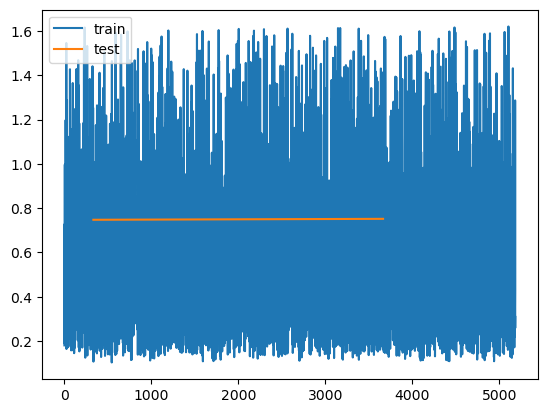

In [169]:
# autoencode last traffic flow, real emb, only cont, divide mse by s, sigma 4, non-relative time, no categorical emb

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

In [151]:

n_epochs = 50
warmup_epochs = n_epochs // 10
encoder_layers = 1
decoder_layers = 1
forward_expansion = 1
heads = 1
embedding_size = 96
sigma = 4


column_groups = {
    'cont_cols': cont_cols,
}

categorical_cols = {
    'Protocol': 256,
    'Inbound': 2,
}

epoch_length = len(train_dataloader.dataset)

train_losses = []
test_losses  = []
train_counter = []
test_counter = [i * epoch_length for i in range(n_epochs + 1)]

train_loss_dict = {}
test_loss_dict = {}


loss_fn = GeneratedLoss(
    categorical_cols,
    column_groups,
    device
)

batch_0 = None

model = TrafficFlowTransformer(
    categorical_cols,
    column_groups,
    embedding_size=embedding_size,
    encoder_layers=encoder_layers,
    encoder_forward_expansion=forward_expansion,
    encoder_heads=heads,
    decoder_layers=decoder_layers,
    decoder_forward_expansion=forward_expansion,
    decoder_heads=heads,
    device=device,
    sigma=sigma,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer,
#     T_max=n_epochs,
#     eta_min=0.0001
# )

iteration = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    minibatch_counter = 0
    message = f"Epoch: {epoch}, Train Loss:"

    

    for batch in train_dataloader:

        minibatch_counter += 1

        X_time = batch[0]
        y_time = batch[3]

        X_cat = batch[1]
        y_cat = batch[4]

        X_cont_group = batch[2]
        X_cont_group_dict = {
            group: X_cont_group[i] for i, group in enumerate(column_groups.keys())
        }


        y_cont_group = batch[5]
        y_cont_group_dict = {
            group: y_cont_group[i] for i, group in enumerate(column_groups.keys())
        }
        # print(X_cat.size())

        y_cont_pred, y_cat_pred = model(
            X_time,
            X_cat,
            X_cont_group_dict,
            y_time,
            y_cat,
            y_cont_group_dict
        )

        loss = loss_fn(
            y_cat_pred,
            y_cont_pred,
            y_cat,
            y_cont_group
        )

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if iteration < 20 and epoch == 0:
            print(f'iter {iteration} loss: {loss.item()}')

        train_loss_dict[iteration] = loss.item()


        iteration += 1
        
    # scheduler.step()

    train_loss /= minibatch_counter
    # train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    message += f" {train_loss}"

    if epoch % 10 == 0:

        model.eval()
        with torch.no_grad():
            test_loss = 0
            test_minibatch_counter = 0

            for batch in test_dataloader:

                test_minibatch_counter += 1

                X_time = batch[0]
                y_time = batch[3]

                X_cat = batch[1]
                y_cat = batch[4]

                X_cont_group = batch[2]
                X_cont_group_dict = {
                    group: X_cont_group[i] for i, group in enumerate(column_groups.keys())
                }


                y_cont_group = batch[5]
                y_cont_group_dict = {
                    group: y_cont_group[i] for i, group in enumerate(column_groups.keys())
                }

                y_cont_pred, y_cat_pred = model(
                    X_time,
                    X_cat,
                    X_cont_group_dict,
                    y_time,
                    y_cat,
                    y_cont_group_dict
                )

                test_loss += loss_fn(
                    y_cat_pred,
                    y_cont_pred,
                    y_cat,
                    y_cont_group
                )

            test_loss /= test_minibatch_counter
            # test_loss /= len(test_dataloader.dataset)
            test_losses.append(test_loss.item())

            test_loss_dict[iteration] = test_loss.item()

            message += f", Test Loss: {test_loss.item()}"

    print(message)

# model.target_mask(3)

iter 0 loss: 0.647934079170227
iter 1 loss: 0.7963764071464539
iter 2 loss: 0.29353660345077515
iter 3 loss: 0.14997974038124084
iter 4 loss: 0.579847514629364
iter 5 loss: 0.6206009984016418
iter 6 loss: 0.36373987793922424
iter 7 loss: 2.9185092449188232
iter 8 loss: 0.1546819657087326
iter 9 loss: 0.2279197722673416
iter 10 loss: 0.4452076256275177
iter 11 loss: 0.8585418462753296
iter 12 loss: 0.22455857694149017
iter 13 loss: 0.44215914607048035
iter 14 loss: 1.4419782161712646
iter 15 loss: 0.11743522435426712
iter 16 loss: 0.6283164620399475
iter 17 loss: 0.36350271105766296
iter 18 loss: 1.7898632287979126
iter 19 loss: 0.5281804203987122
Epoch: 0, Train Loss: 0.8410467460483044, Test Loss: 0.8512009978294373
Epoch: 1, Train Loss: 0.839358926602491
Epoch: 2, Train Loss: 0.8389342235283809
Epoch: 3, Train Loss: 0.849440414022218


KeyboardInterrupt: 

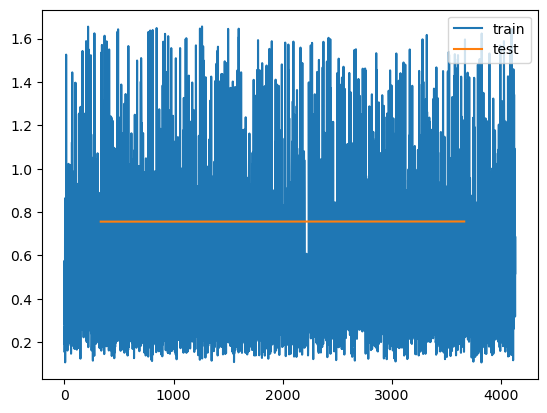

In [ ]:
# autoencode last traffic flow, real emb, only cont, divide mse by s, sigma 4, non-relative time

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

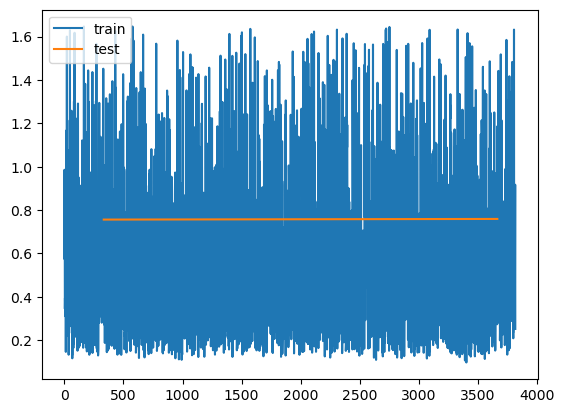

In [136]:
# autoencode last traffic flow, real emb, only cont, divide mse by s, sigma 1, non-relative time

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

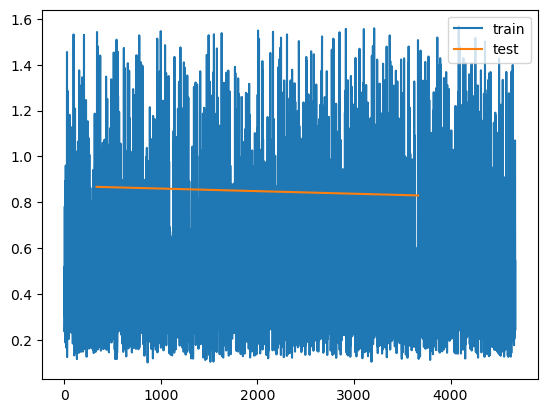

In [125]:
# autoencode last traffic flow, real emb, only cont, divide mse by s, sigma 1

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

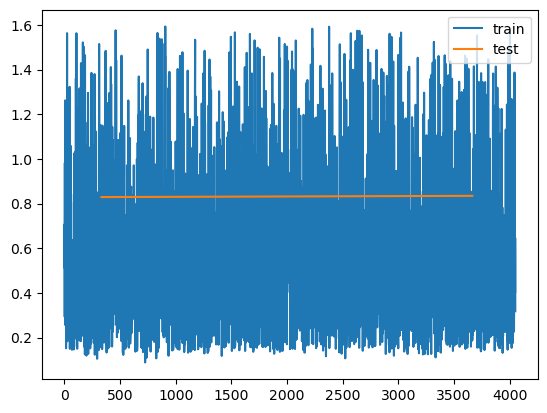

In [123]:

# autoencode last traffic flow, real emb, only cont, divide mse by s, sigma 20

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

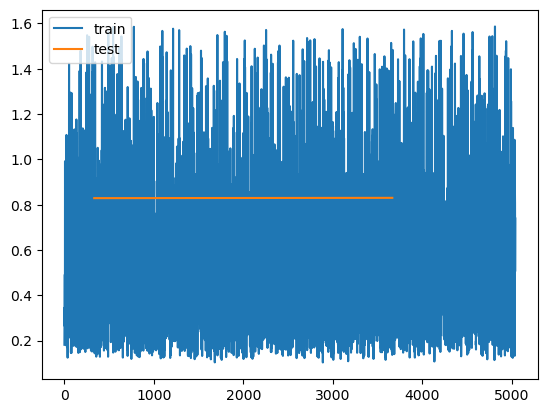

In [111]:
# autoencode last traffic flow 2, dummy emb, only cont, divide mse by s

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

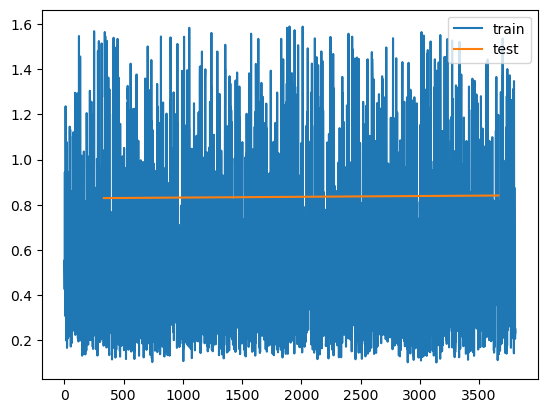

In [107]:
# autoencode last traffic flow 2, real emb, only cont, divide mse by s

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

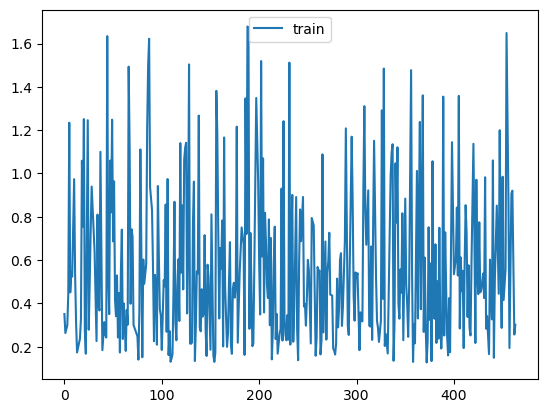

In [105]:
# autoencode last traffic flow, real emb, only cont, divide mse by s

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

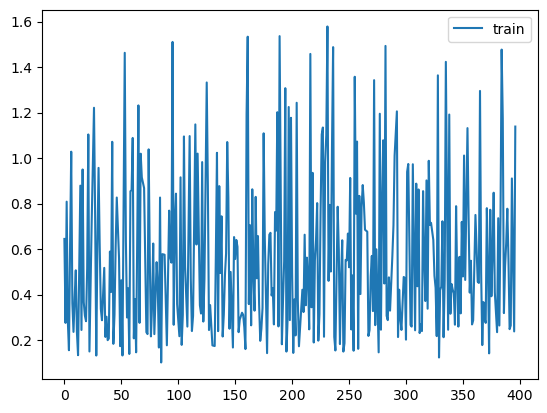

In [101]:
# autoencode last traffic flow, fake emb, only cont, divide mse by s

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

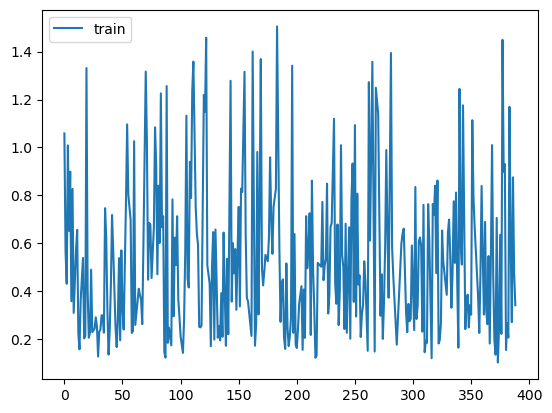

In [ ]:
# Predict next traffic flow, real emb, only cont, divide mse by s

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

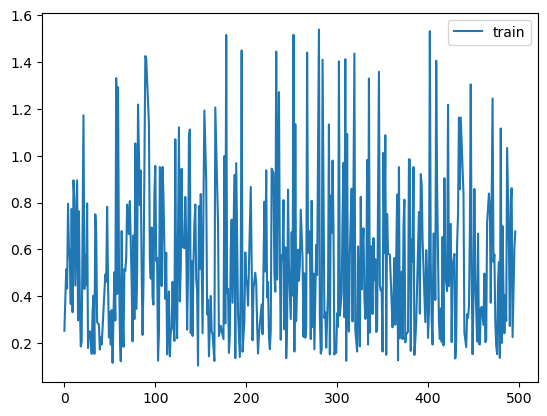

In [ ]:
# Predict next traffic flow, real emb, only cont, not divide mse by s

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

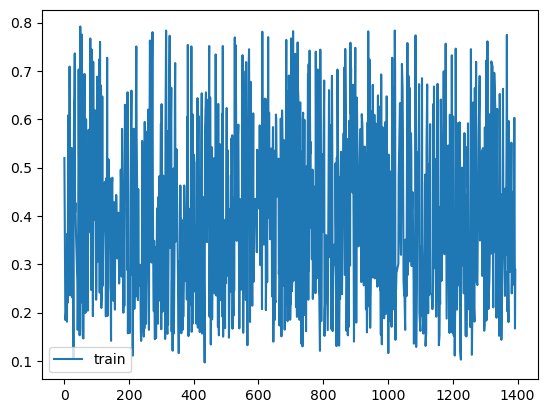

In [82]:
# Predict next traffic flow, real emb, only cont

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

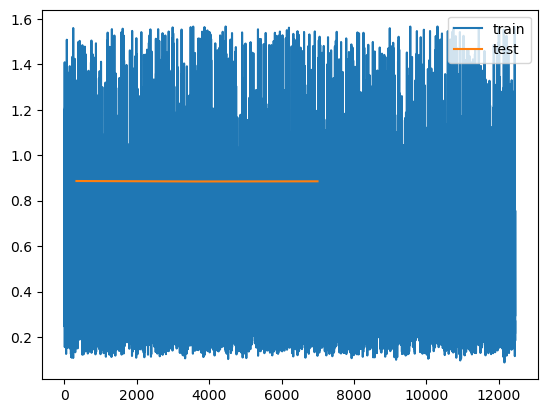

In [78]:
# Predict next traffic flow, dummy emb, only cont

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

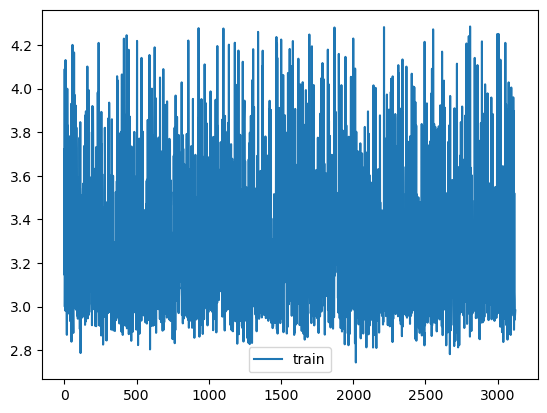

In [70]:
# Predict next traffic flow

# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

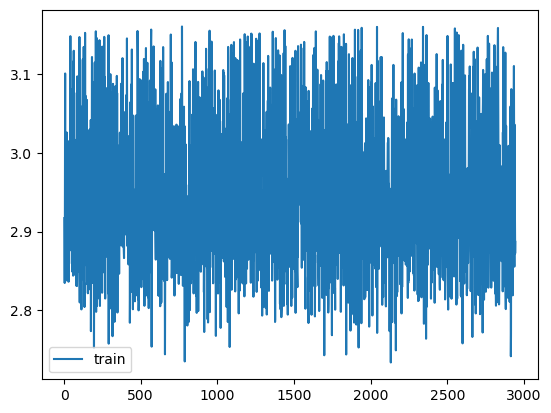

In [47]:
# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

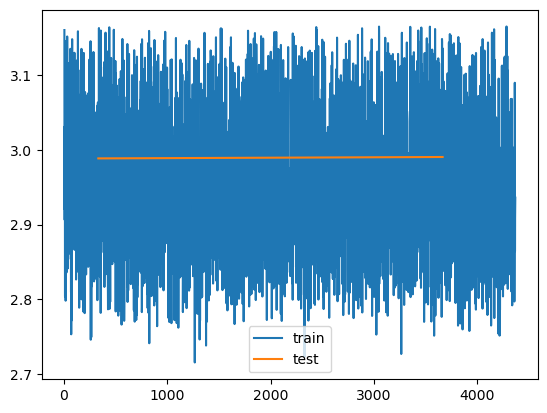

In [43]:
# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

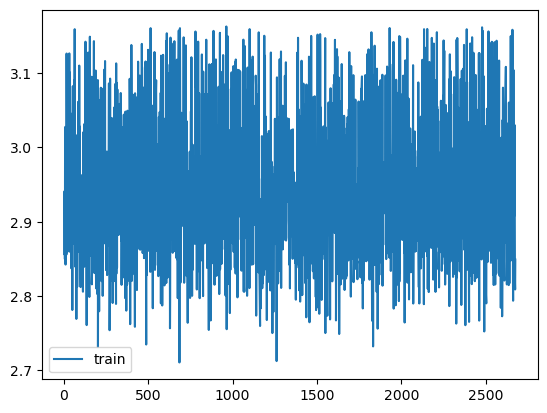

In [41]:
# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

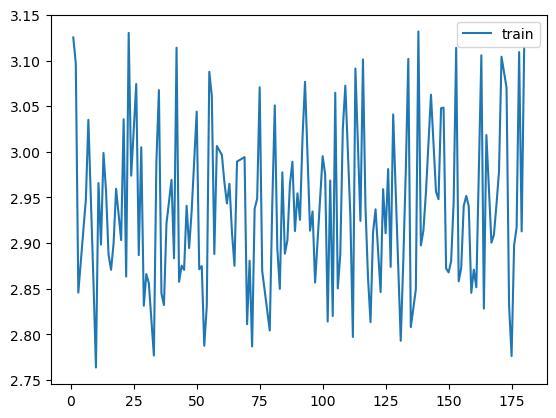

In [39]:
# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

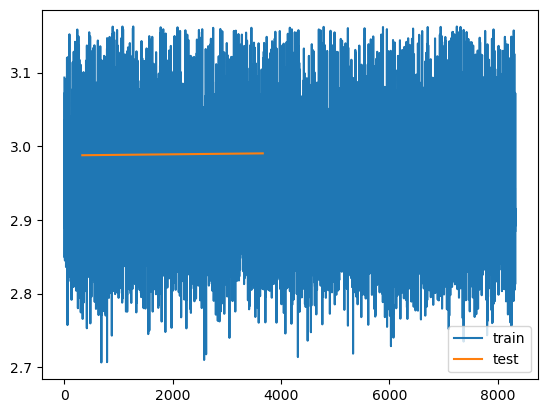

In [35]:
# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

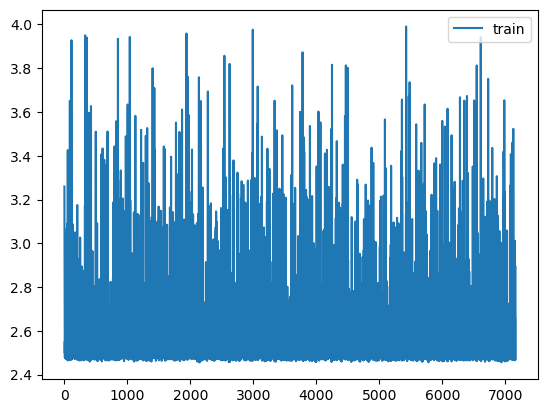

In [108]:
# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

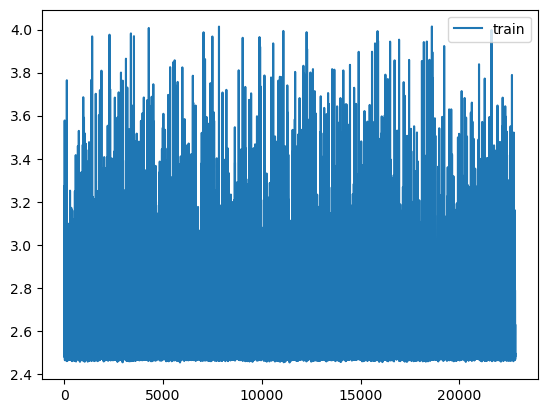

In [104]:
# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

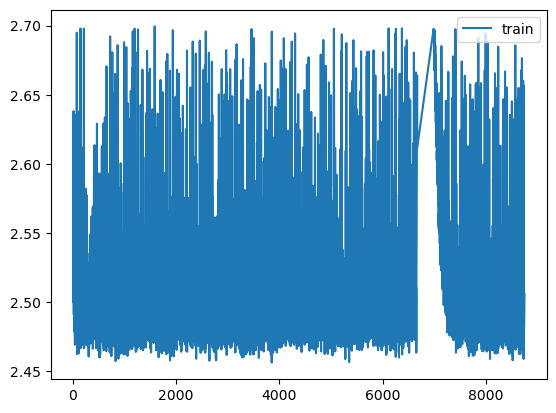

In [102]:
# Now we plot the loss chart using the train and test loss dictionaries

# first, we filter out the test loss values that are outside of 1 standard deviation of the mean using torch
train_mean, train_std = torch.mean(torch.tensor(list(train_loss_dict.values()))), torch.std(torch.tensor(list(train_loss_dict.values())))
test_mean, test_std = torch.mean(torch.tensor(list(test_loss_dict.values()))), torch.std(torch.tensor(list(test_loss_dict.values())))

train_loss_dict = {k: v for k, v in train_loss_dict.items() if v < train_mean + .75*train_std}
test_loss_dict = {k: v for k, v in test_loss_dict.items() if v < test_mean + .75*test_std}

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

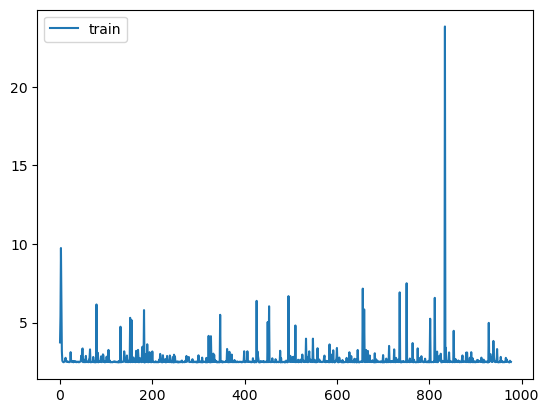

In [97]:
# Now we plot the loss chart using the train and test loss dictionaries

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

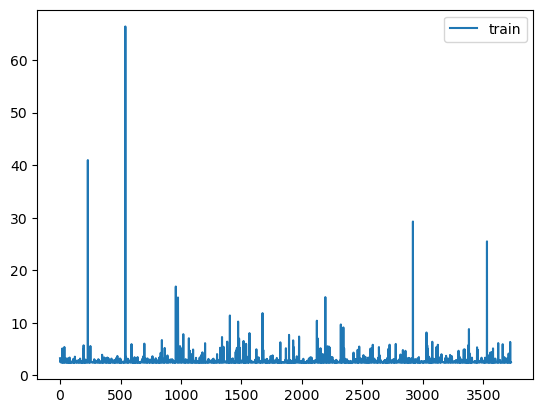

In [95]:
# Now we plot the loss chart using the train and test loss dictionaries

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

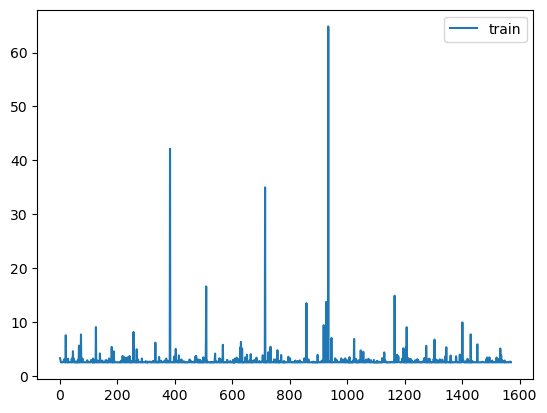

In [93]:
# Now we plot the loss chart using the train and test loss dictionaries

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

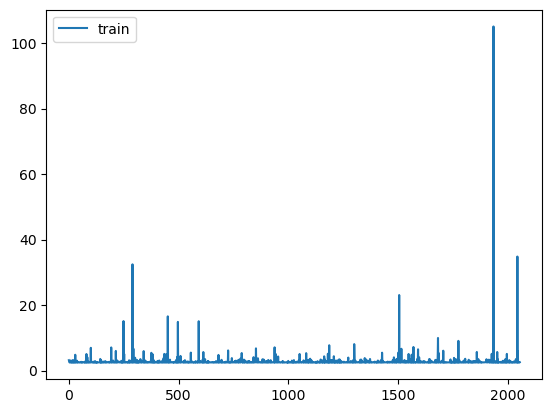

In [ ]:
# Now we plot the loss chart using the train and test loss dictionaries

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

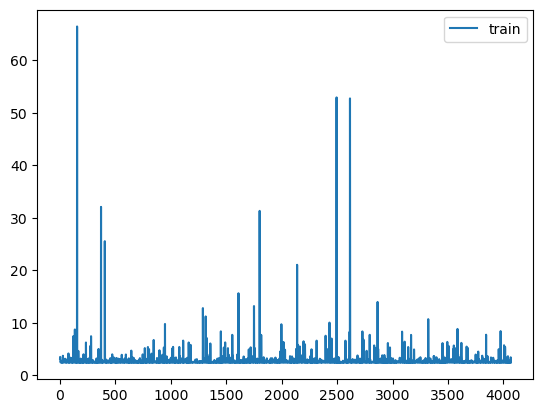

In [81]:
# Now we plot the loss chart using the train and test loss dictionaries

plt.plot(*zip(*sorted(train_loss_dict.items())), label='train')
plt.plot(*zip(*sorted(test_loss_dict.items())), label='test')
plt.legend()

plt.show()

In [ ]:

n_epochs = 1

column_groups = {
    'speed_cols': speed_cols,
    'length_cols': length_cols,
    'min_cols': min_cols,
    'max_cols': max_cols,
    'mean_cols': mean_cols,
    'std_cols': std_cols,
}

categorical_cols = {
    'Protocol': 256,
    'Inbound': 2,
}

epoch_length = len(train_dataloader.dataset)

train_losses = []
test_losses  = []
train_counter = []
test_counter = [i * epoch_length for i in range(n_epochs + 1)]


loss_fn = GeneratedLoss(
    categorical_cols,
    device
)

batch_0 = None

model = TrafficFlowTransformer(
    categorical_cols,
    column_groups,
    embedding_size=128,
    device=device,
)

# print(model)

for epoch in range(n_epochs):
    model.train()
    # model.eval()

    for batch in train_dataloader:
        X_time = batch[0]
        y_time = batch[8]

        X_cat = batch[1]
        y_cat = batch[9]

        X_cont_group = batch[2:8]
        X_cont_group_dict = {
            group: X_cont_group[i] for i, group in enumerate(column_groups.keys())
        }


        y_cont_group = batch[10:]
        y_cont_group_dict = {
            group: y_cont_group[i] for i, group in enumerate(column_groups.keys())
        }
        # print(X_cat.size())

        y_cat_pred, y_cont_group = model(
            X_time,
            X_cat,
            X_cont_group_dict,
            y_time,
            y_cat,
            y_cont_group_dict
        )

        break
    break


model.target_mask(3)

In [ ]:
batch_size = 2
source_sequence_length = 10
target_sequence_length = 3
target_sequence_offset = 8

embedding_size = 4

test_time_vals = torch.arange(0, target_sequence_length).repeat(batch_size, embedding_size)
test_full_targ_vals = torch.arange(target_sequence_length, 2 * target_sequence_length)
print(test_time_vals.shape)
print(test_time_vals.size(1))
print(test_full_targ_vals.shape)
print(test_time_vals)
print(test_full_targ_vals)

In [ ]:
test_vals = torch.arange(0, target_sequence_length).reshape(1, target_sequence_length, 1).repeat(batch_size, 1, embedding_size)
test_vals

In [ ]:
test_vals = test_vals.reshape(batch_size, target_sequence_length, 1, embedding_size).repeat(1, 1, 2, 1).reshape(batch_size, target_sequence_length*2, embedding_size)
test_vals

In [ ]:
targ_vals = torch.arange(target_sequence_length, target_sequence_length * 2).reshape(1, target_sequence_length, 1).repeat(batch_size, 1, embedding_size)
targ_vals


In [ ]:
# in test_vals, we replace every other element of the first dimension with an element from targ_vals
test_vals[:, 1::2, :] = targ_vals
test_vals

In [ ]:
# now we remove all the elements that were replaced

test_vals[:, 0::2, :]